# Import Packages

In [ ]:
import pandas as pd

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras import optimizers


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from ipywidgets import HTML
import ipywidgets as widgets
from ipyleaflet import Map, Polyline, Rectangle, basemaps, basemap_to_tiles, Polygon, FullScreenControl, Popup, WidgetControl

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np

import os

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

import sys
sys.path.append('/datc/saab/notebooks')

Using GPU 2

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [8]:
#Configure TensorFlow
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
set_session(sess)

# Defining variables & Importing data

In [9]:
variables = ['latitude', 'longitude', 'speed']
time_steps = 2

In [10]:
from saab import datasets
data = datasets.reduced_area()

#Take the mmsi's appart (they dont need to get scaled)
print('Taking appart MMSIS & SCALING .........', end = '')
ID_df = data[['mmsi']].values

#Get the variables from the data
x = data[variables].values #returns a numpy array
#define a scaler
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
#join the mmsi to the scaled data
x_scaled = np.array([np.append(ID_df[i],x_scaled[i]) for i in range(len(ID_df))])

#Convert it to a dataframe
data = pd.DataFrame(x_scaled, columns = ['mmsi'] + variables)
print('[OK]')
#Get ships info
print('Geting sequences of movements.........', end='')
CRAFT_ID_list = data.mmsi.unique()#Get the mmsi unique values into a list:
CRAFT_ID_list = CRAFT_ID_list[CRAFT_ID_list!=0]
ships_info = [[] for j in range(len(CRAFT_ID_list))]#List that will storage a list of lists == a list of time-series(which will as well be represented as a list)

for i, rowid in enumerate(CRAFT_ID_list):
    #Start with empty lists
    npinfo = []
    #Get a numpy array composed by 'latitude', 'longitude', 'orientation', 'length', 'breadth'
    npinfo = data[data.mmsi == rowid][variables].values
    #Convert it to a python list so it can be an attribute of the multypoligon functionality of ipyleaflet
    ships_info[i]=npinfo
print('[OK]')
#Get the steps of timesteps size from the data 
input_data = []
output_data = []
aditional_input = []
print('Getting input and output data .........', end='')

for ship in ships_info:
    for i in range(len(ship)//time_steps):
        input_data.append(ship[time_steps*i:time_steps*i+time_steps-1])
        aditional_input.append([ship[j+1][:2] - ship[j][:2] for j in range(time_steps*i, time_steps*i+time_steps-1)])
        output_data.append(ship[time_steps*i+time_steps-1])
print('[OK]')

Taking appart MMSIS & SCALING .........[OK]
Geting sequences of movements.........[OK]
Getting input and output data .........[OK]


# Defining inputs and outputs

In [11]:
input_data = np.array(input_data)
output_data = np.array(output_data)
aditional_input = np.array(aditional_input)
input_data = input_data.reshape(input_data.shape[0], input_data.shape[1]*input_data.shape[2])
#output_data = output_data.reshape(output_data.shape[0], output_data.shape[1]*output_data.shape[2])
aditional_input = aditional_input.reshape(aditional_input.shape[0], aditional_input.shape[1]*aditional_input.shape[2])

# Operative function

In [7]:
def train_model(layers_num, neurons_per_layer, lr, eps, data, X_train, X_test, y_train, y_test, ships_info):
    print('*'*52)
    print('* ' + ('LAYERS: ' + str(layers_num)).center(49, ' ') + '*')
    print('* ' + ('MODEL: ' + str(neurons_per_layer)).center(49, ' ') + '*')
    print('* ' + ('LEARNING RATE: ' + str(lr)).center(49, ' ') + '*')
    print('* ' + (' EPOCHS: ' + str(eps)).center(49, ' ') + '*')
    print('*'*52)
    
    
    #reshape the data
    #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    #X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
    #Create the model
    print('Creating Model .........',end='')
    model = Sequential()
    for i in range(layers_num):
        if i == 0:
            model.add(Dense(neurons_per_layer[i], input_shape=(len(X_train[0]),)))
        else:
            model.add(Dense(neurons_per_layer[i]))
            
    model.add(Dense(len(variables)))
    model.compile(optimizer = optimizers.Adam(lr=lr)
                  , loss='mse', metrics=['accuracy', 'mae'])
    print('[OK]')
    history = model.fit(X_train, y_train,
              batch_size=150, epochs=eps,
              validation_data=(X_test, y_test))
    model.summary()
    
    
    
    #Plot val-train graphs
    plt.figure(figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('MODEL ACCURACY')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MODEL LOSS')
    plt.yscale('log')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    #Get predictions of the model
    y_pred = model.predict(X_test, batch_size = 150)
    
    #Unscale the input data
    X_test = X_test[:,:len(variables)].reshape(X_test.shape[0], X_test.shape[1]//len(variables), len(variables))
    X_test_unscaled = [scaler.inverse_transform(elem) for elem in X_test]
    
    #unscale the predictions
    Y_pred = scaler.inverse_transform(y_pred)
    
    #unscale test data
    y_test_unscaled = scaler.inverse_transform(y_test)
 
    return max([len(element) for element in ships_info]), X_test_unscaled, y_test_unscaled, Y_pred
def rgb_to_hex(rgb):
    if len(rgb) == 4:
        rgb = rgb[:3]
    return '#%02x%02x%02x' % tuple(list([int(elem*256) for elem in rgb]))
def random_hex_color():
    import random
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))

# Define the partitions for training-test and training multiple models iterating over a for-loop

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [100, 100]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 5s - loss: 0.7752 - acc: 0.4928 - mean_absolute_error: 0.6894 - val_loss: 0.6046 - val_acc: 0.5569 - val_mean_absolute_error: 0.6076
Epoch 2/10
305995/305995 [==============================] - 5s - loss: 0.4653 - acc: 0.6503 - mean_absolute_error: 0.5293 - val_loss: 0.3441 - val_acc: 0.7562 - val_mean_absolute_error: 0.4534
Epoch 3/10
305995/305995 [==============================] - 5s - loss: 0.2496 - acc: 0.8285 - mean_absolute_error: 0.3809 - val_loss: 0.1689 - val_acc: 0.8793 - val_mean_absolute_error: 0.3105
Epoch 4/10
305995/3059

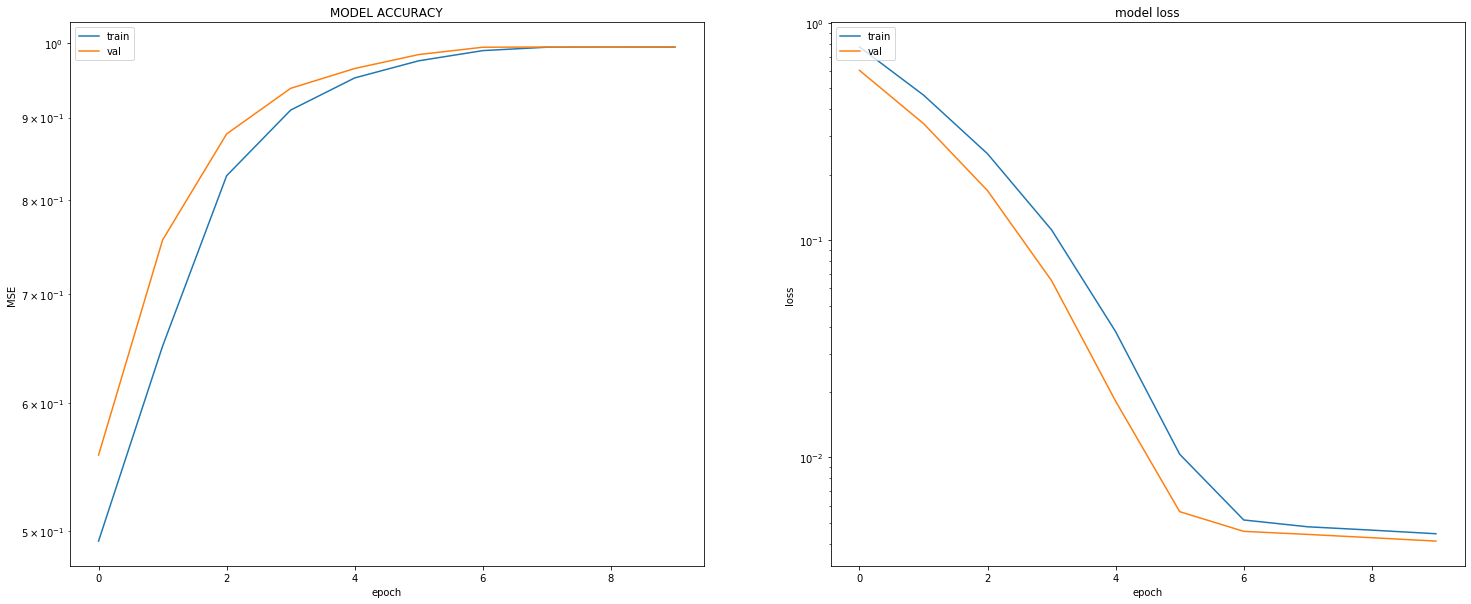

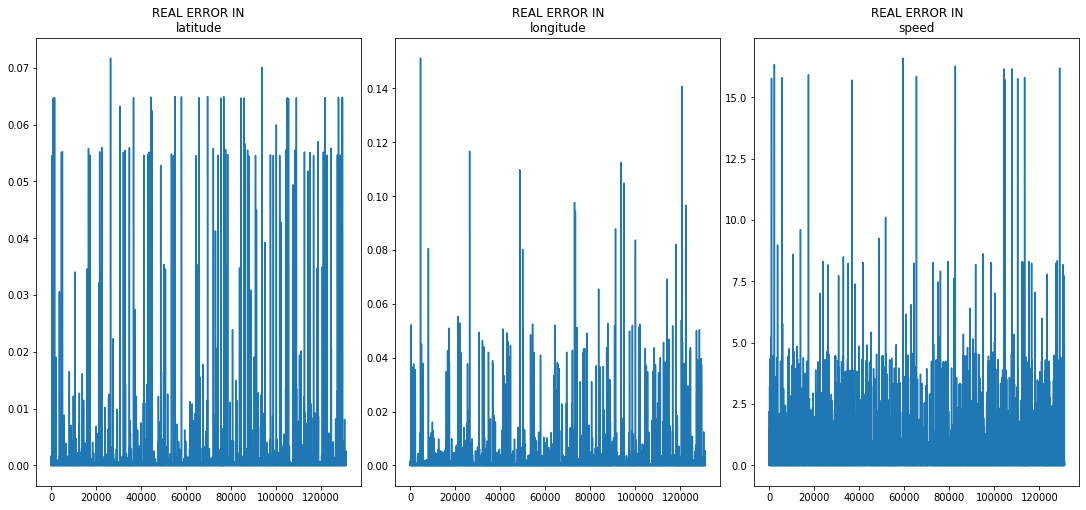

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [200, 200]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 5s - loss: 0.8016 - acc: 0.5872 - mean_absolute_error: 0.6925 - val_loss: 0.4803 - val_acc: 0.7696 - val_mean_absolute_error: 0.5379
Epoch 2/10
305995/305995 [==============================] - 5s - loss: 0.2811 - acc: 0.8770 - mean_absolute_error: 0.4021 - val_loss: 0.1331 - val_acc: 0.9539 - val_mean_absolute_error: 0.2771
Epoch 3/10
305995/305995 [==============================] - 5s - loss: 0.0626 - acc: 0.9733 - mean_absolute_error: 0.1787 - val_loss: 0.0194 - val_acc: 0.9820 - val_mean_absolute_error: 0.0961
Epoch 4/10
305995/3059

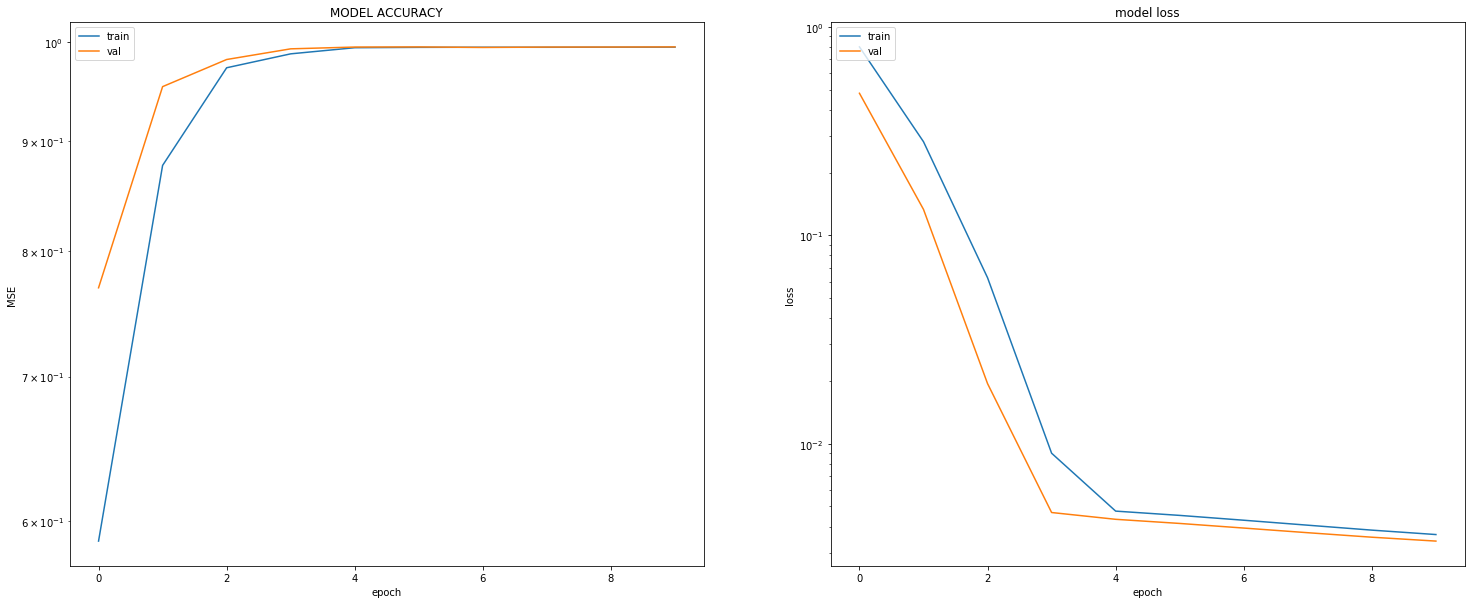

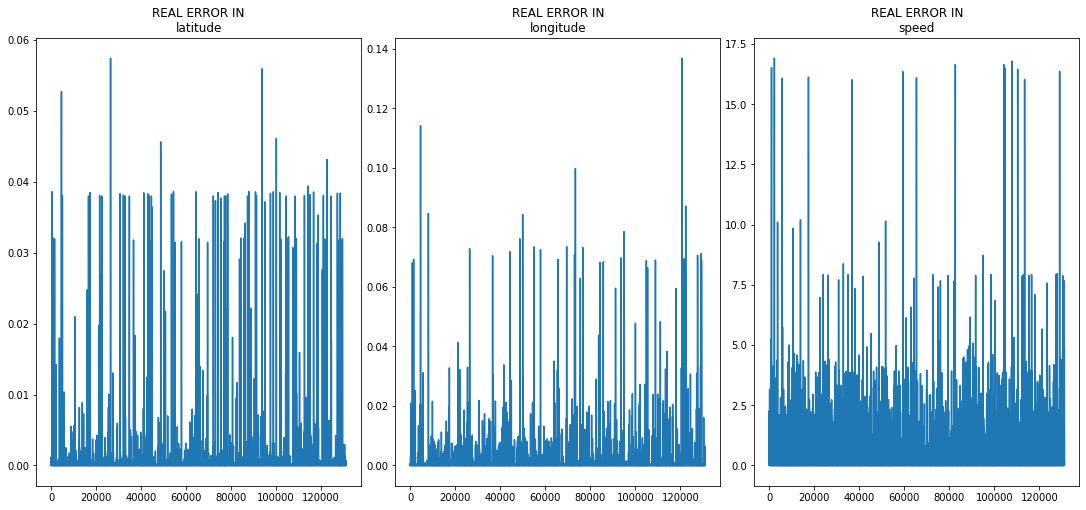

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [300, 300]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 6s - loss: 0.5769 - acc: 0.7447 - mean_absolute_error: 0.5906 - val_loss: 0.2326 - val_acc: 0.9313 - val_mean_absolute_error: 0.3790
Epoch 2/10
305995/305995 [==============================] - 5s - loss: 0.0952 - acc: 0.9583 - mean_absolute_error: 0.2241 - val_loss: 0.0206 - val_acc: 0.9780 - val_mean_absolute_error: 0.1013
Epoch 3/10
305995/305995 [==============================] - 5s - loss: 0.0083 - acc: 0.9867 - mean_absolute_error: 0.0431 - val_loss: 0.0044 - val_acc: 0.9942 - val_mean_absolute_error: 0.0117
Epoch 4/10
305995/3059

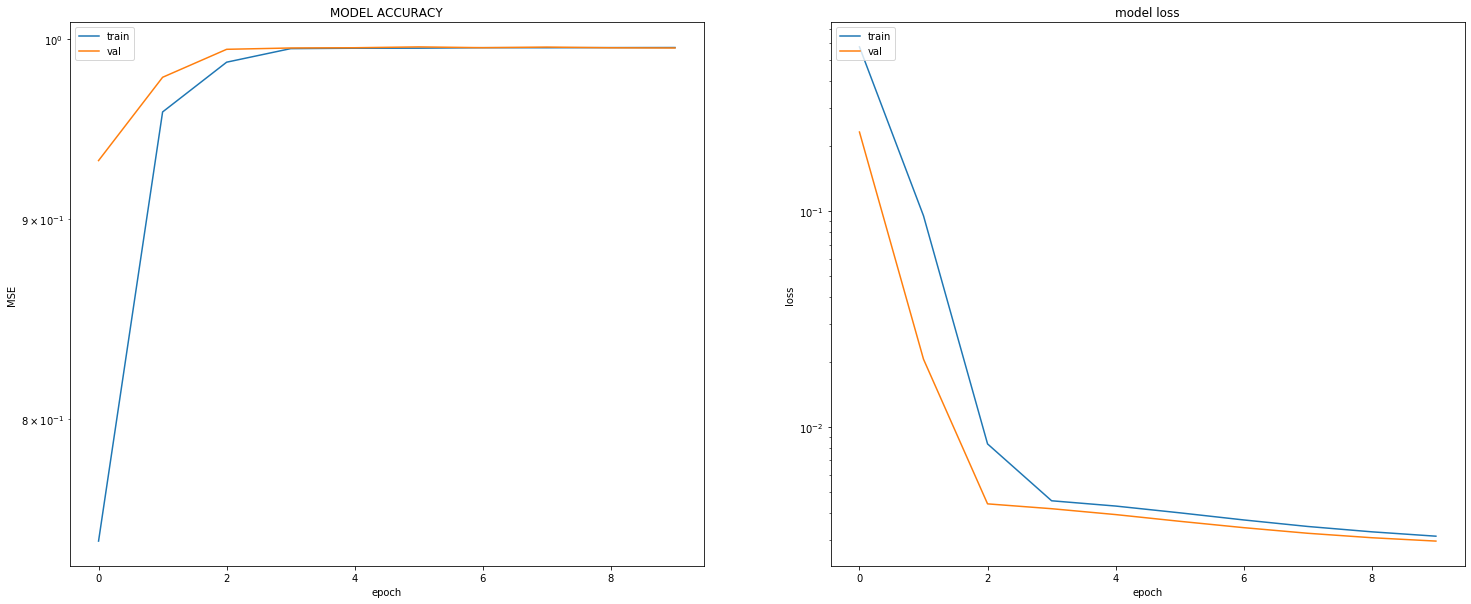

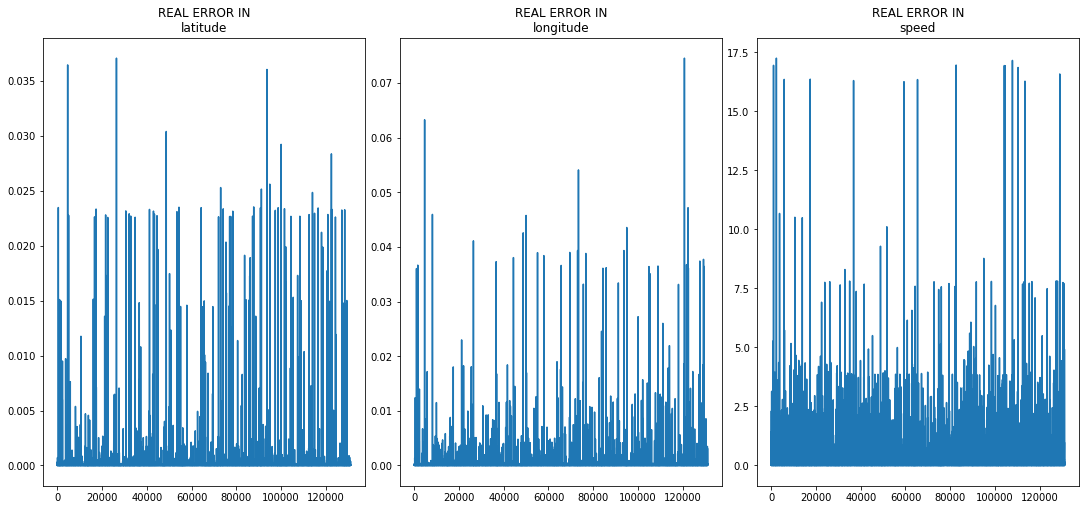

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [400, 400]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 7s - loss: 0.5086 - acc: 0.8058 - mean_absolute_error: 0.5471 - val_loss: 0.1524 - val_acc: 0.9353 - val_mean_absolute_error: 0.3041
Epoch 2/10
305995/305995 [==============================] - 6s - loss: 0.0512 - acc: 0.9641 - mean_absolute_error: 0.1534 - val_loss: 0.0078 - val_acc: 0.9835 - val_mean_absolute_error: 0.0495
Epoch 3/10
305995/305995 [==============================] - 6s - loss: 0.0049 - acc: 0.9916 - mean_absolute_error: 0.0194 - val_loss: 0.0040 - val_acc: 0.9952 - val_mean_absolute_error: 0.0081
Epoch 4/10
305995/3059

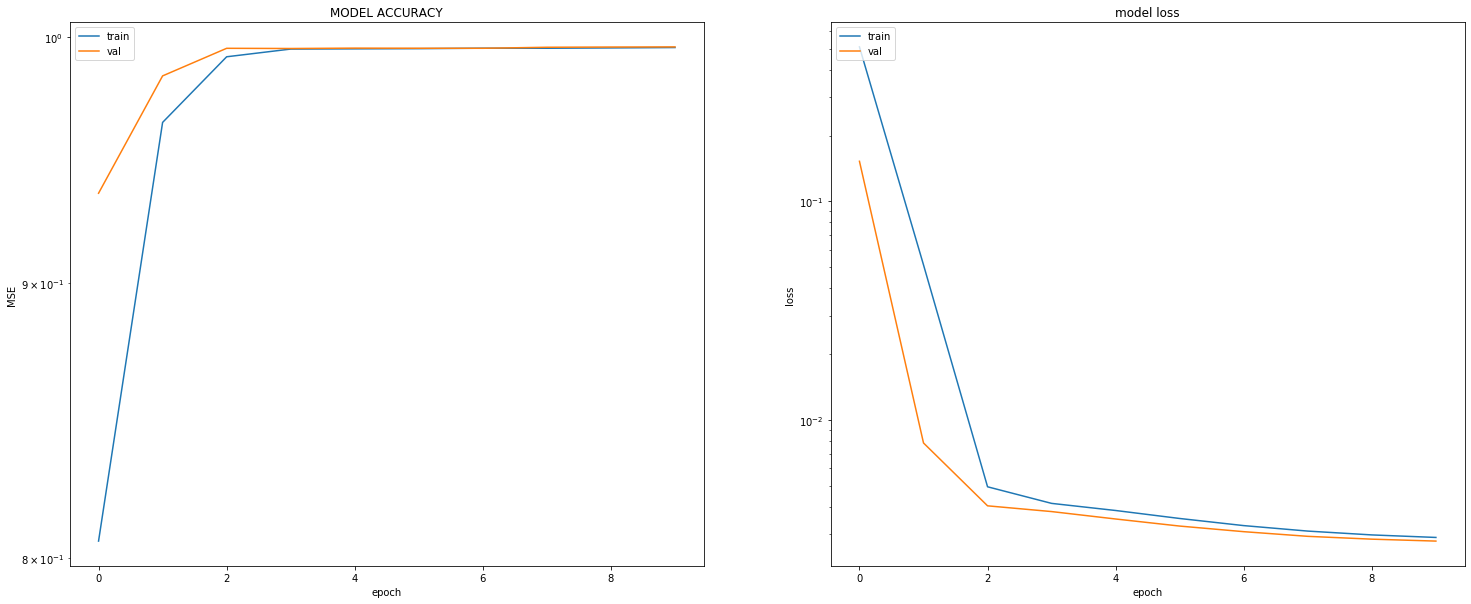

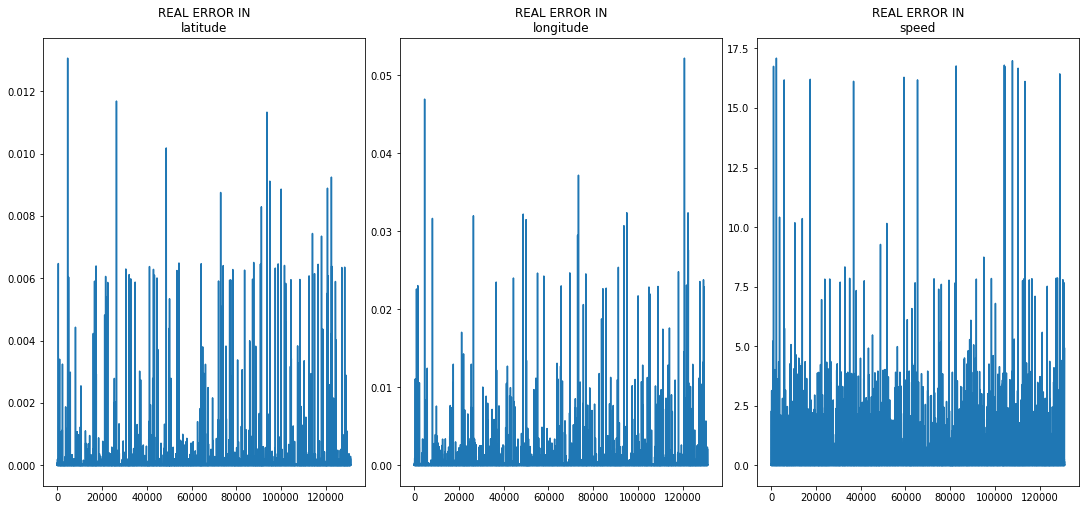

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [500, 500]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 7s - loss: 0.3186 - acc: 0.8863 - mean_absolute_error: 0.4112 - val_loss: 0.0421 - val_acc: 0.9800 - val_mean_absolute_error: 0.1553
Epoch 2/10
305995/305995 [==============================] - 6s - loss: 0.0116 - acc: 0.9889 - mean_absolute_error: 0.0559 - val_loss: 0.0042 - val_acc: 0.9944 - val_mean_absolute_error: 0.0109
Epoch 3/10
305995/305995 [==============================] - 6s - loss: 0.0043 - acc: 0.9948 - mean_absolute_error: 0.0085 - val_loss: 0.0039 - val_acc: 0.9948 - val_mean_absolute_error: 0.0080
Epoch 4/10
305995/3059

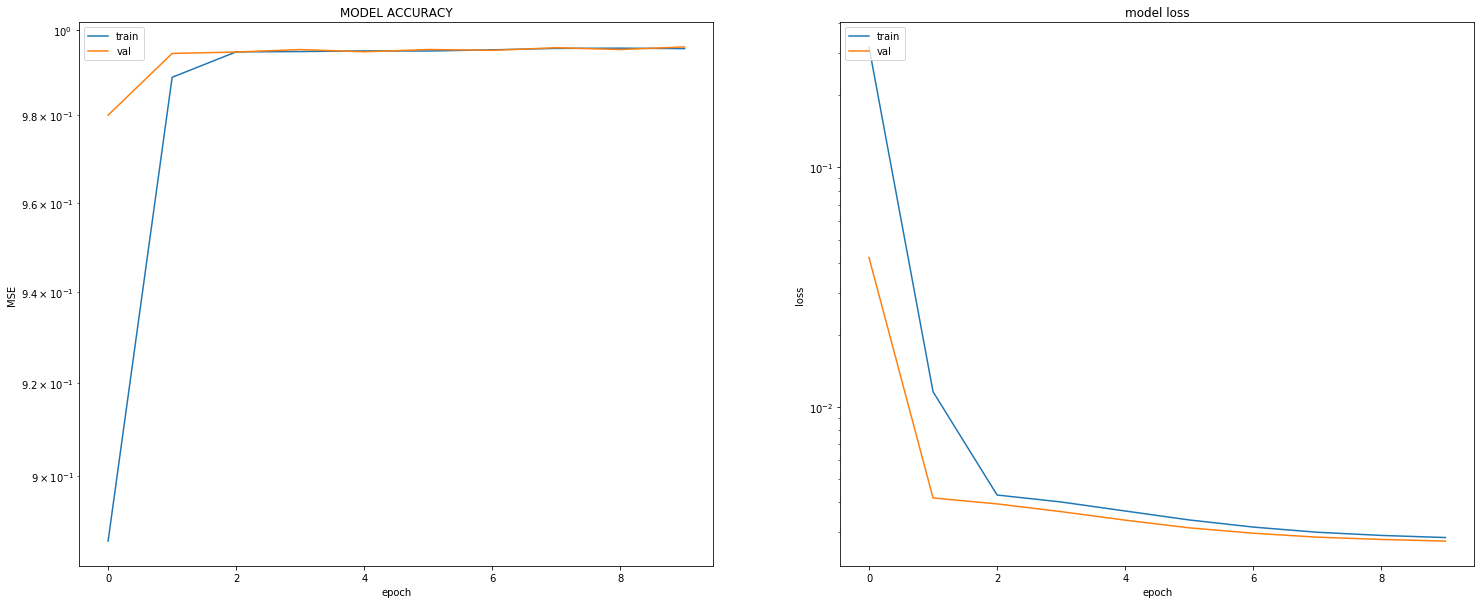

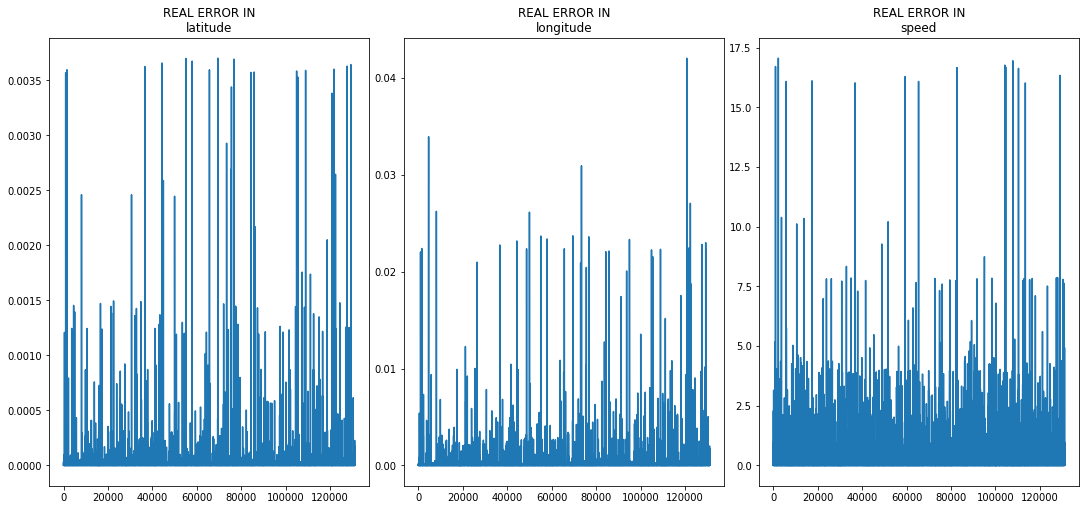

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [600, 600]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 8s - loss: 0.2965 - acc: 0.9132 - mean_absolute_error: 0.3882 - val_loss: 0.0235 - val_acc: 0.9809 - val_mean_absolute_error: 0.1121
Epoch 2/10
305995/305995 [==============================] - 7s - loss: 0.0074 - acc: 0.9901 - mean_absolute_error: 0.0352 - val_loss: 0.0042 - val_acc: 0.9950 - val_mean_absolute_error: 0.0087
Epoch 3/10
305995/305995 [==============================] - 7s - loss: 0.0043 - acc: 0.9948 - mean_absolute_error: 0.0082 - val_loss: 0.0039 - val_acc: 0.9951 - val_mean_absolute_error: 0.0078
Epoch 4/10
305995/3059

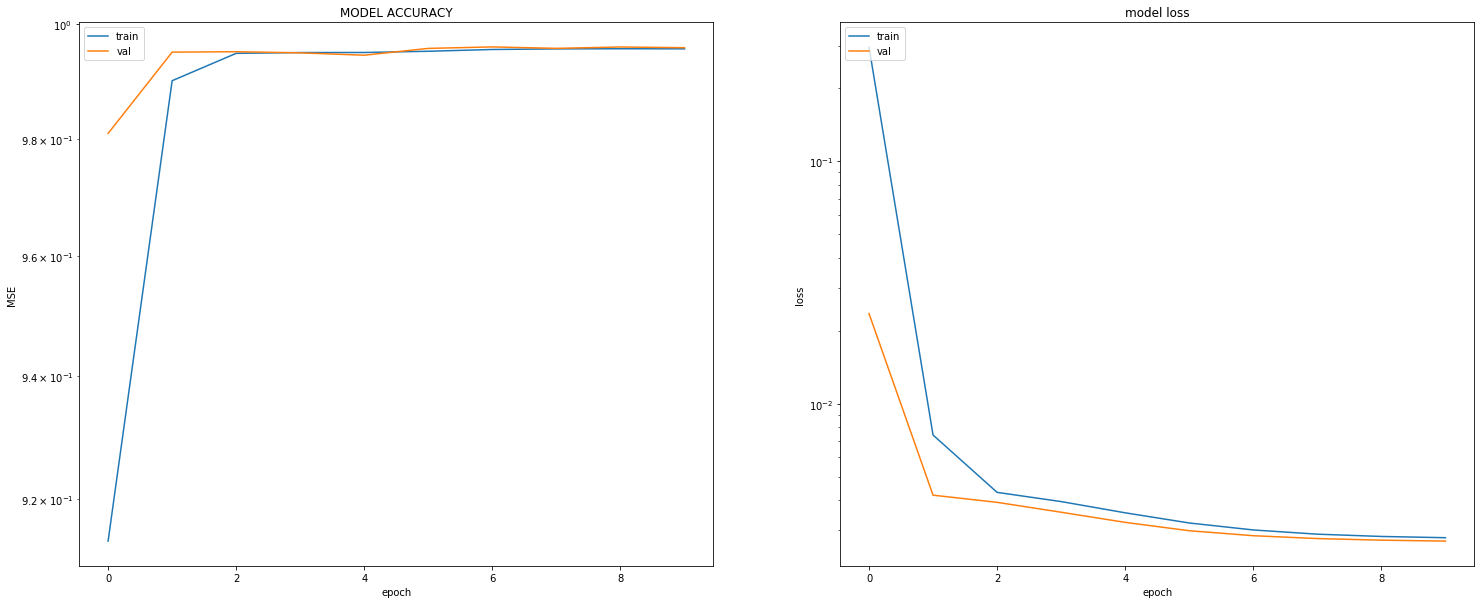

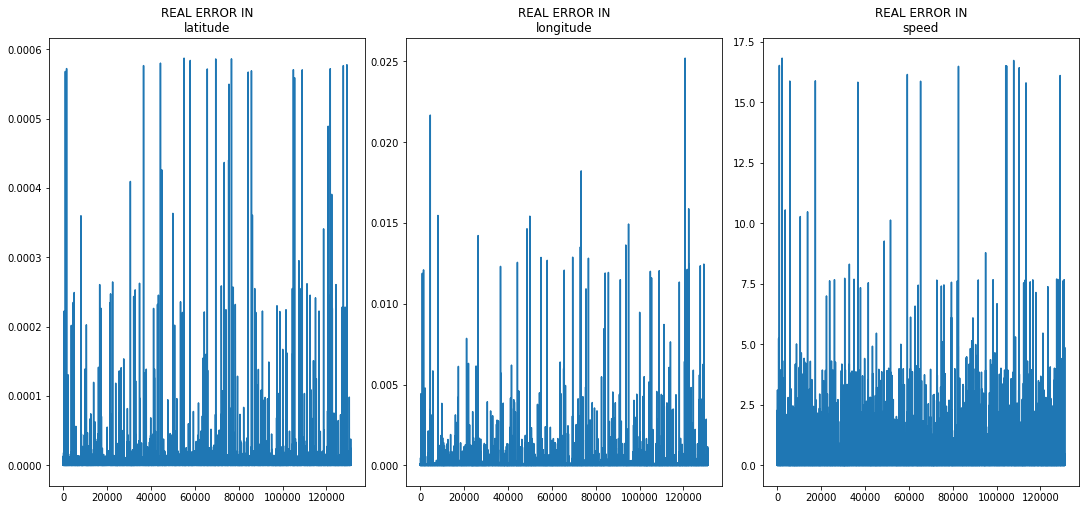

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [700, 700]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 9s - loss: 0.2572 - acc: 0.9023 - mean_absolute_error: 0.3500 - val_loss: 0.0132 - val_acc: 0.9772 - val_mean_absolute_error: 0.0776
Epoch 2/10
305995/305995 [==============================] - 8s - loss: 0.0057 - acc: 0.9897 - mean_absolute_error: 0.0239 - val_loss: 0.0042 - val_acc: 0.9945 - val_mean_absolute_error: 0.0084
Epoch 3/10
305995/305995 [==============================] - 8s - loss: 0.0043 - acc: 0.9947 - mean_absolute_error: 0.0082 - val_loss: 0.0039 - val_acc: 0.9949 - val_mean_absolute_error: 0.0080
Epoch 4/10
305995/3059

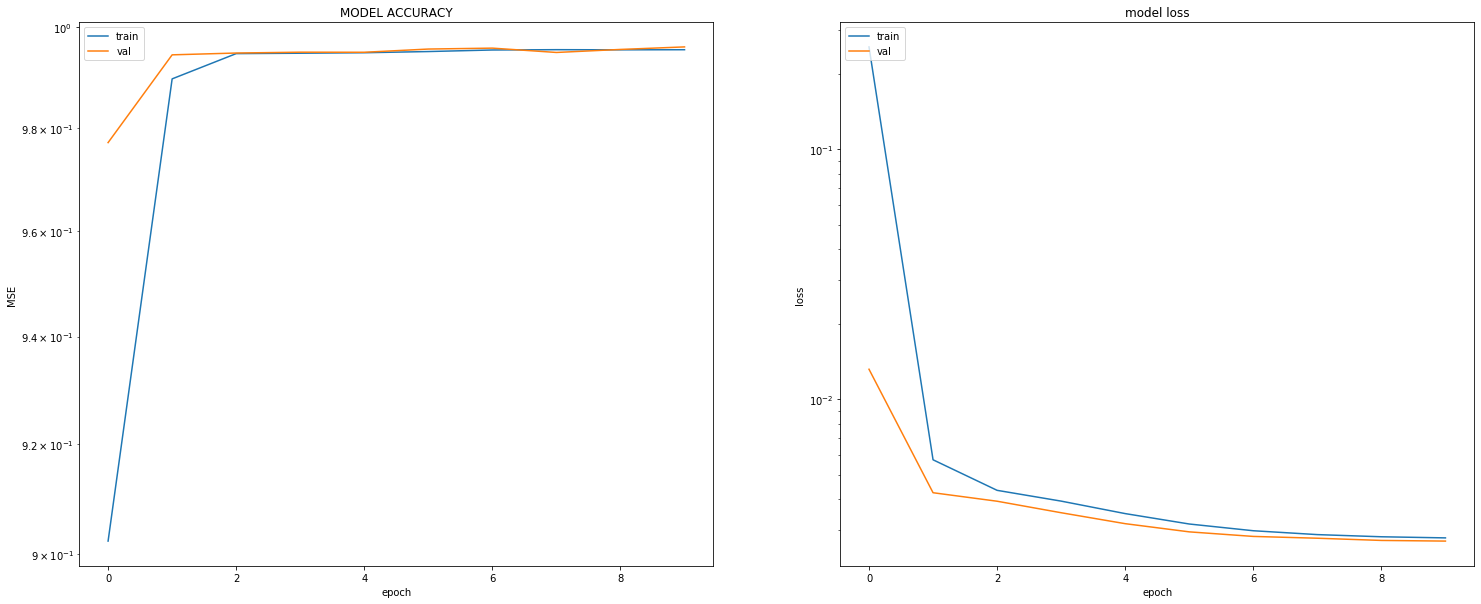

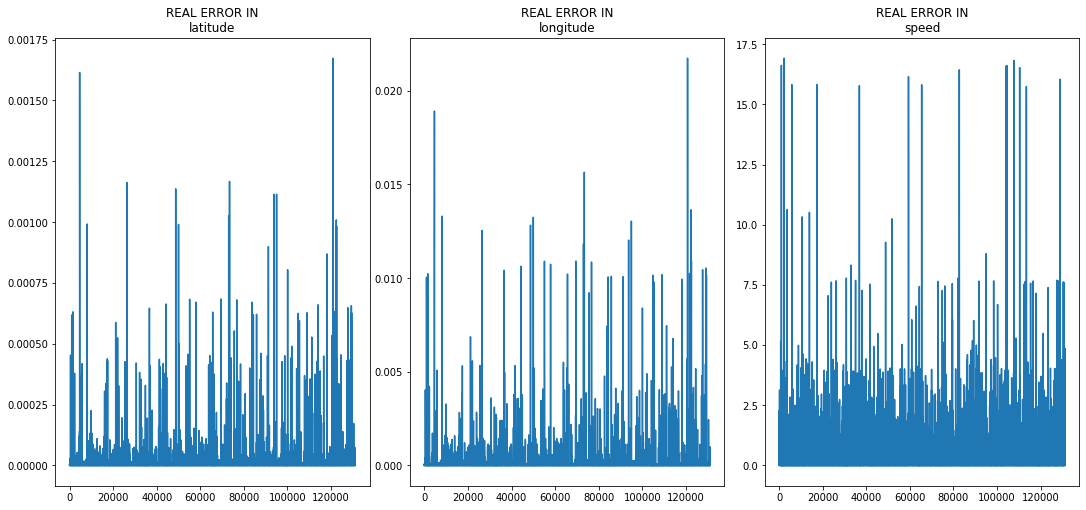

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [800, 800]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 10s - loss: 0.2757 - acc: 0.9123 - mean_absolute_error: 0.3586 - val_loss: 0.0113 - val_acc: 0.9842 - val_mean_absolute_error: 0.0705
Epoch 2/10
305995/305995 [==============================] - 9s - loss: 0.0052 - acc: 0.9922 - mean_absolute_error: 0.0209 - val_loss: 0.0040 - val_acc: 0.9950 - val_mean_absolute_error: 0.0081
Epoch 3/10
305995/305995 [==============================] - 9s - loss: 0.0041 - acc: 0.9949 - mean_absolute_error: 0.0080 - val_loss: 0.0037 - val_acc: 0.9949 - val_mean_absolute_error: 0.0080
Epoch 4/10
305995/305

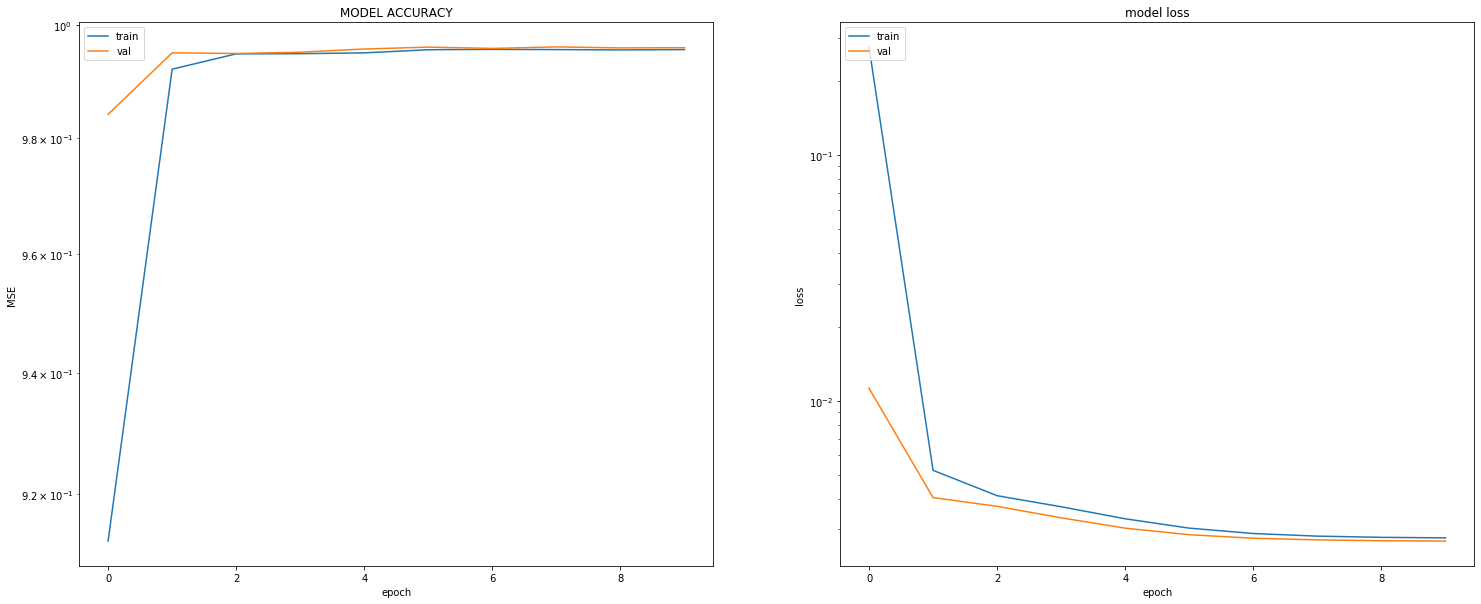

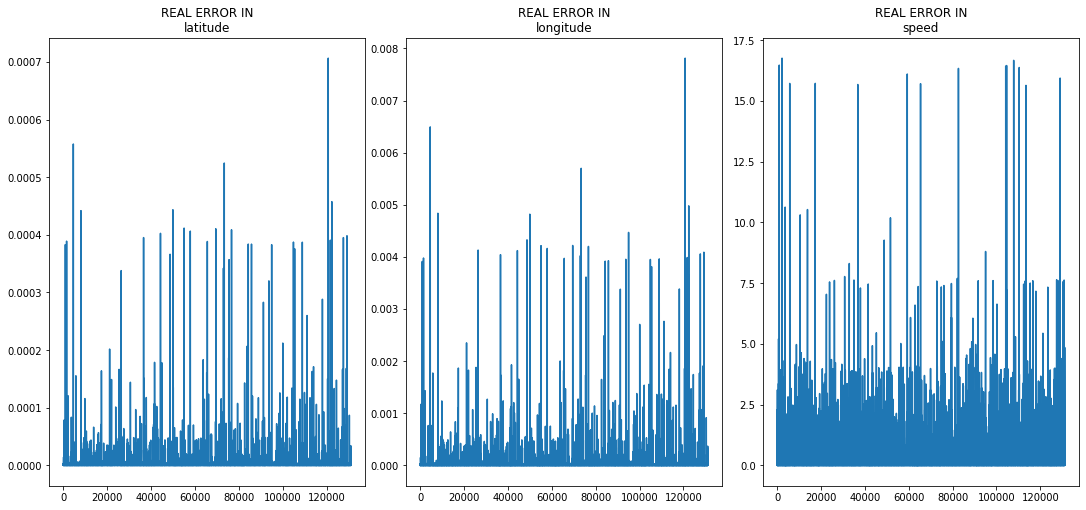

****************************************************
*                     LAYERS: 2                    *
*                 MODEL: [900, 900]                *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 12s - loss: 0.2140 - acc: 0.9293 - mean_absolute_error: 0.2950 - val_loss: 0.0062 - val_acc: 0.9877 - val_mean_absolute_error: 0.0387
Epoch 2/10
305995/305995 [==============================] - 11s - loss: 0.0047 - acc: 0.9931 - mean_absolute_error: 0.0132 - val_loss: 0.0041 - val_acc: 0.9951 - val_mean_absolute_error: 0.0077
Epoch 3/10
305995/305995 [==============================] - 11s - loss: 0.0041 - acc: 0.9949 - mean_absolute_error: 0.0080 - val_loss: 0.0037 - val_acc: 0.9952 - val_mean_absolute_error: 0.0074
Epoch 4/10
305995/3

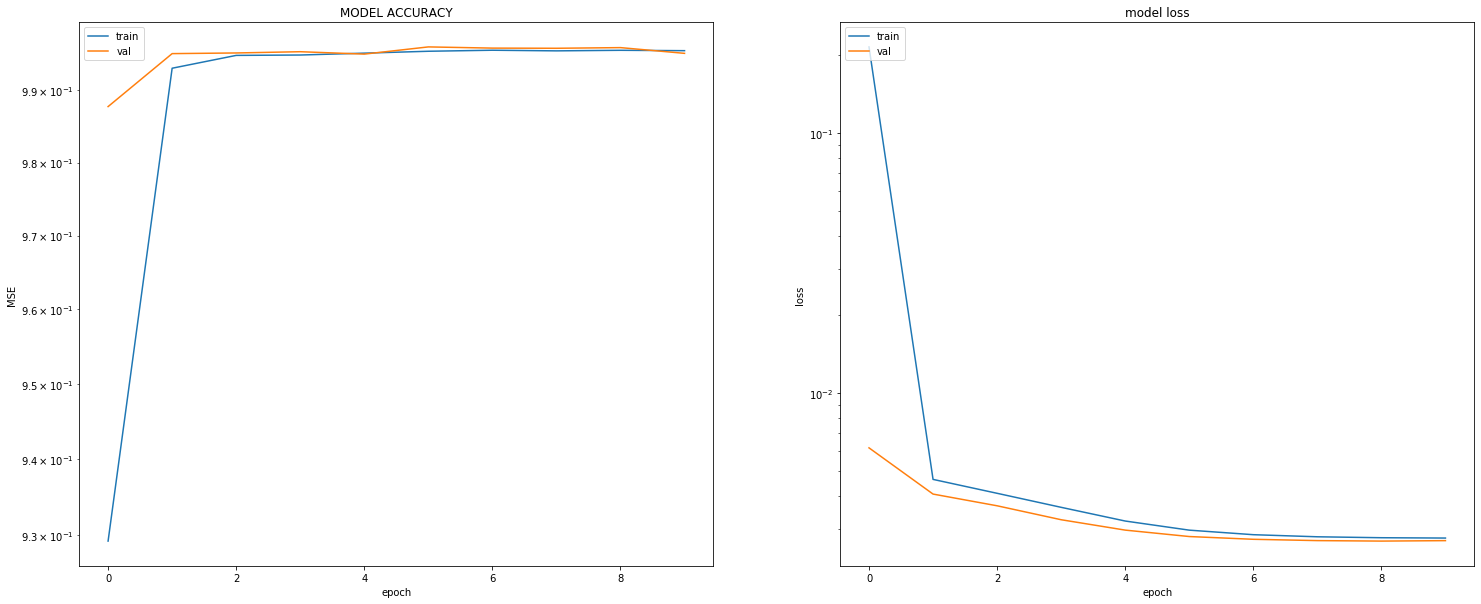

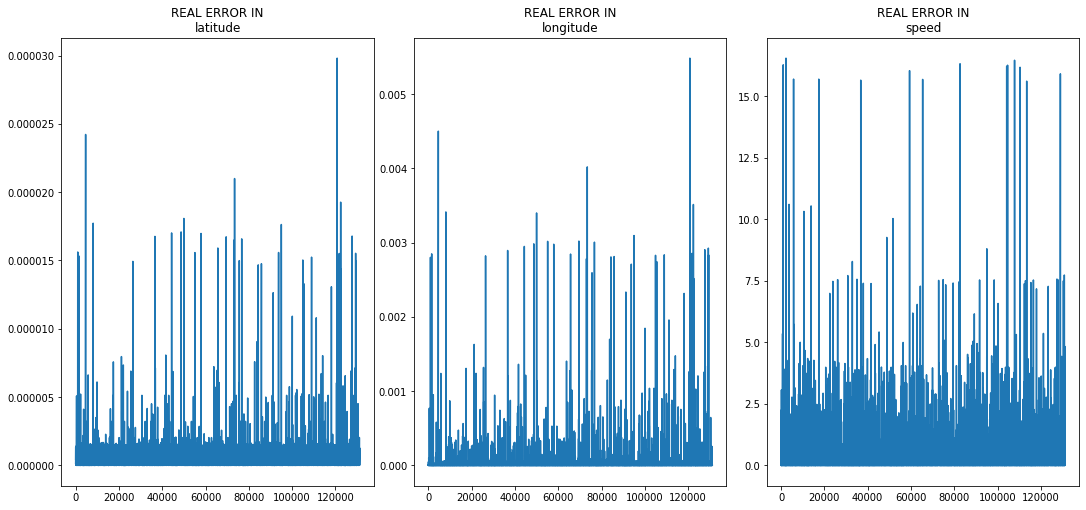

****************************************************
*                     LAYERS: 2                    *
*                MODEL: [1000, 1000]               *
*                LEARNING RATE: 1e-06              *
*                     EPOCHS: 10                   *
****************************************************
Creating Model .........[OK]
Train on 305995 samples, validate on 131141 samples
Epoch 1/10
305995/305995 [==============================] - 13s - loss: 0.1875 - acc: 0.9557 - mean_absolute_error: 0.2608 - val_loss: 0.0048 - val_acc: 0.9925 - val_mean_absolute_error: 0.0217
Epoch 2/10
305995/305995 [==============================] - 13s - loss: 0.0045 - acc: 0.9945 - mean_absolute_error: 0.0100 - val_loss: 0.0040 - val_acc: 0.9950 - val_mean_absolute_error: 0.0078
Epoch 3/10
305995/305995 [==============================] - 13s - loss: 0.0040 - acc: 0.9948 - mean_absolute_error: 0.0079 - val_loss: 0.0036 - val_acc: 0.9936 - val_mean_absolute_error: 0.0091
Epoch 4/10
305995/3

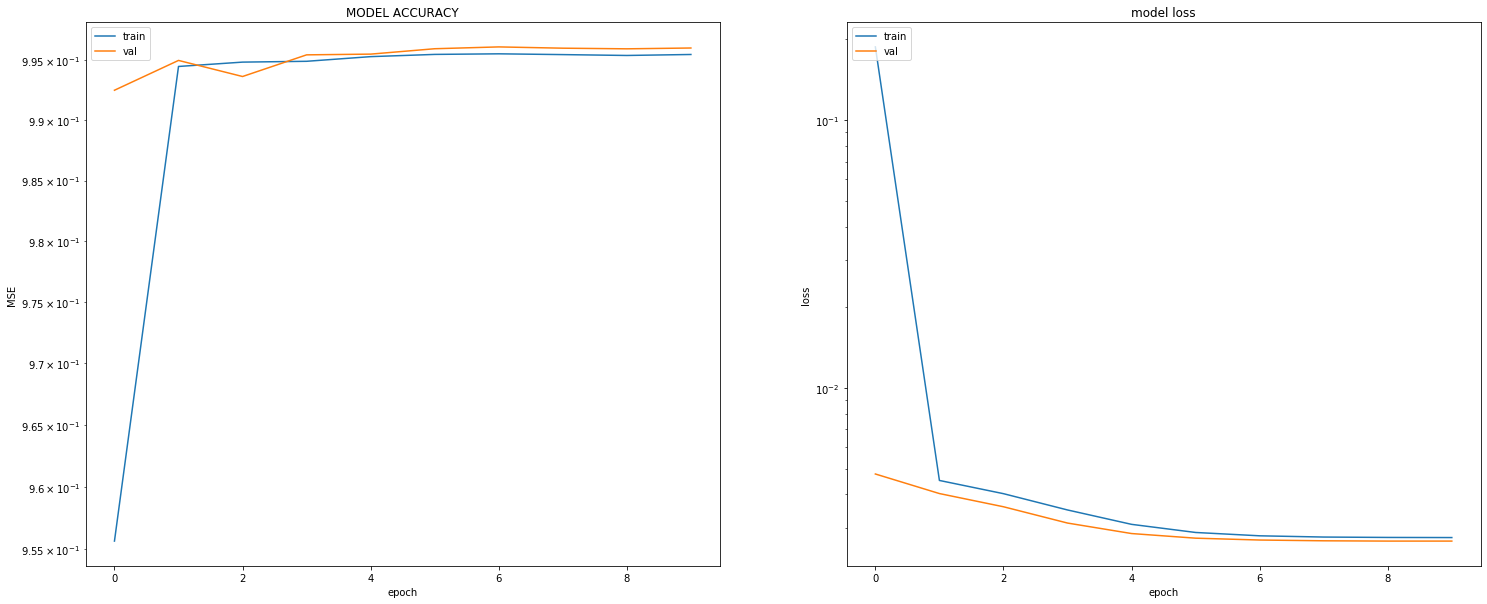

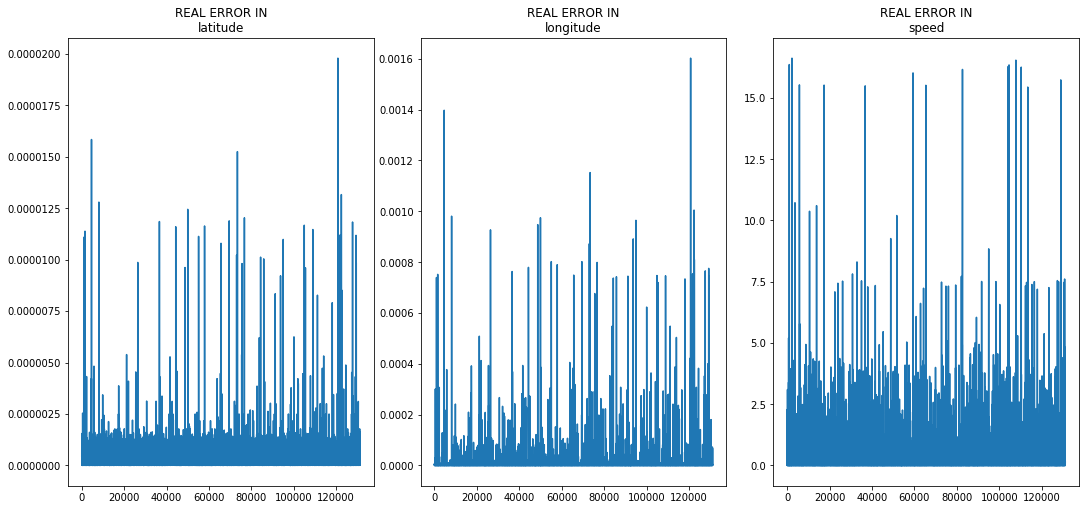

In [12]:
#Split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((input_data, aditional_input), axis=1), output_data, test_size=0.3)

#for layers in range(2,4,1):
for neurons1 in range(100,1100,100):
#    for neurons2 in range(100,1100,100):
#            for neurons3 in range(900,1100,100):
    max_steps, X_test_unscaled, y_test_unscaled, Y_pred = train_model(layers, [neurons1, neurons1], 1e-6, 10, data, X_train, X_test, y_train, y_test, ships_info)

    plt.figure(figsize=(15, 7))
    for i in range(len(variables)):
        plt.subplot(1,3, (i+1))
        plt.title('REAL ERROR IN\n' + variables[i])
        plt.plot(abs(y_test_unscaled[:,i]-Y_pred[:,i]))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

# Visualize results on the map

In [ ]:
m = Map(center = (-25.353548853000003, -43.935133436), zoom =10)#Define the map object

#To define  the maximum number of steps we will be able to take with the slider
ships_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max_steps,
    step=1,
    description='Ships: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
widget_steps = WidgetControl(widget=ships_slider, position='topright')
m.add_control(widget_steps)
m.add_control(FullScreenControl())
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_matter_layer)
previous_value = 0


def update_map(ships_slider):
    global previous_value, m
    if previous_value > ships_slider:
        m = Map(center = (-22.884059, 133.714373), zoom =10)#Define the map object
        ini, end = 0, ships_slider
    else:
        ini, end = previous_value, ships_slider
        
    for i in range(ini, end):
        color_value = random_hex_color()
        #for each time series in ships_info list --> Paint The line
        
        pred_line = Polyline(
            #last unscaled Location value ---> Predicted next values
            locations = [[X_test_unscaled[i][-1][0], X_test_unscaled[i][-1][1]], [Y_pred[i][0], Y_pred[i][1]]],
            color = 'green',
            fill_color= "transparent",
            weight = 3,
            opacity = 1)
        m.add_layer(pred_line)
        
        real_line_y = Polyline(
            #Unscaled values  ----> Unscaled target value
            locations = [[X_test_unscaled[i][-1][0], X_test_unscaled[i][-1][1]]] + [[y_test_unscaled[i][0], y_test_unscaled[i][1]]],
            color = 'blue',
            fill_color= "transparent",
            weight = 3,
            opacity = 1)
        
        m.add_layer(real_line_y)
        
        real_line_x = Polyline(
        locations = [[elem[0],elem[1]] for elem in X_test_unscaled[i]],
        color = color_value,
        fill_color= "transparent",
        weight = 3,
        opacity = 1)
        
        m.add_layer(real_line_x)
    previous_value = ships_slider
    display(m)
widgets.interactive(update_map, ships_slider=ships_slider)